# Part 2: Feature Engineering, Modeling, & Evaluation

## Imports

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import xgboost               as xgb
from math                    import sqrt
from sklearn.linear_model    import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics         import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor
from sklearn.pipeline        import Pipeline
from IPython.core.display    import display, HTML
from IPython.display         import display_html
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

## Table Of Contents


- [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    
    
    
- [Feature Engineering](#Feature-Engineering)
    - [Transforming Numeric Data](#Transforming-Numeric-Data)
    - [Creating Segmental Features](#Creating-Segmental-Features)
        
    
    
- [Modeling](#Modeling)
    - [Functions](#Functions)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [LASSO](#LASSO)
    - [ElasticNetCV](#ElasticNetCV)
    - [Random Forest Reression](#Random-Forest-Regression)
    - [XGBoosting](#XGBoosting)
    - [Prediction Dataframes](#Prediction-Dataframes)
     
     
    
- [Model Evaluation](#Model-Evaluation)
    - [Functions](#Evaluation-Functions)
    - [Plotting Predictions](#Plotting-Predictions)
    - [Plotting Residuals](#Plotting-Residuals)
    - [Final Model Selection](#Final-Model-Selection)

## Reading In The Data

In [2]:
mri = pd.read_csv("../Data/mri_cleaned.csv")

### Overview

In [3]:
mri.head()

,sex,age,hypertension,hyperlipidemia,diabetes,lvedv,lvesv,lv_wall_thickness,lvef,aortic_stenosis,...,mis_ischemia,mi_ischemia,mil_ischemia,mal_ischemia,aa_ischemia,as_ischemia,ai_ischemia,al_ischemia,smoker_status_former,smoker_status_never
0,1,37,0,0,0,613,501,0,18,0,...,0,0,0,0,0,0,0,0,0,1
1,1,74,0,1,0,569,492,1,14,0,...,0,0,0,0,0,1,0,1,0,1
2,1,78,1,1,1,564,500,0,11,0,...,1,1,0,0,1,1,0,0,0,1
3,1,61,0,1,0,531,435,1,18,0,...,0,0,0,0,0,0,0,0,0,1
4,1,53,0,0,0,522,408,0,21,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Checking the shape of the data

print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 48)


In [5]:
# Summary of column data types

mri.dtypes.value_counts()

int64    48
dtype: int64

## Feature Engineering

### Transforming Numeric Data

There are only four numeric columns in the data set: `age`, `lvesv`, `lvedv`, `lvef`.  Of the four, only `lvef` does not have any kind of a normal distribution: `age` is close to being normally distributed, while `lvesv` and `lvedv` are log-normally distributed.

We were hesitant to transform `lvedv` because that is the target variable, but we can take the log of `lvesv` (in this case the natural log).  We also tried squaring `age` but that did not affect the distribution in the way we hoped it would.

In [6]:
# Creating a new column equal to the natural log of `lvesv`.

mri["lvesv_log"] = mri["lvesv"].apply(lambda x: np.log(x))

# Checking the number of columns

print(f"The data set has {mri.shape[1]} columns.")

The data set has 49 columns.


[Top](#Table-Of-Contents)

### Creating Segmental Features

Because the model attempts to predict the end diastolic volume, we want it to be as accurate as it can be.  As part of that, we will try to use different combinations of features in an attempt to achieve high accuracy.

The data have 34 columns that we wish to engineer: a column measuring scarification and a column measuring ischemia.  Because there are so many of them, we felt the need to experiment with how they are passed into the model.  We are unable to create multiplication interaction columns, because there are zeros.  Instead, we elected to create segmental columns by summing similar columns together: we will compare the model's performance with the originals and with the segmental columns.

We used this image to guide our create of segmental columns:

<img src = "../Images/cardiac-segmentation-for-cardiac-perfusion-defects.jpg" alt = "Cardiac Segmentation" height = "750" width = "750">

Case courtesy of Dr Hamid Chalian, <a href="https://radiopaedia.org/">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/47102">rID: 47102</a>

In [7]:
# Creating columns based off of the red, blue, green, and yellow regions.
# We combined the apex and apical regions because there is only one region in the apex.

# New columns for scar tissue

mri["basal_he"]    = mri["ba_he"] + mri["bas_he"] + mri["bis_he"] \
                     + mri["bi_he"] + mri["bil_he"] + mri["bal_he"]
mri["mid_he"]      = mri["ma_he"] + mri["mas_he"] + mri["mis_he"] \
                     + mri["mi_he"] + mri["mil_he"] + mri["mal_he"]
mri["apical_he"]   = mri["aa_he"] + mri["as_he"] + mri["ai_he"] \
                     + mri["al_he"] + mri["apex_he"]

# New columns for ischemia

mri["basal_ischemia"]  = mri["ba_ischemia"] + mri["bas_ischemia"] + mri["bis_ischemia"] \
                         + mri["bi_ischemia"] + mri["bil_ischemia"] + mri["bal_ischemia"]
mri["mid_ischemia"]    = mri["ma_ischemia"] + mri["mas_ischemia"] + mri["mis_ischemia"] \
                         + mri["mi_ischemia"] + mri["mil_ischemia"] + mri["mal_ischemia"]
mri["apical_ischemia"] = mri["aa_ischemia"] + mri["as_ischemia"] + mri["ai_ischemia"] \
                         + mri["al_ischemia"]

# Checking that the number of columns has increased

print(f"The the data set has {mri.shape[1]} columns.")

The the data set has 55 columns.


We intended to create new columns based off the secondary axis (antero-septal, infero-septal, etc.) but because of how the apical region is divided we would have counted the apical regions more than once.

[Top](#Table-Of-Contents)

One of our goals was to see what would happen if we used the engineered features to reduce the overall number of features being passed into the model.  To accomplish that, we created two dataframes: one with the original set of features (48 including the target) and a second one with the engineered features (21 including the target).


From this point on, `_org` will be used to refer to the original set of features and `_eng` will be use to refer to the engineered features.  The default will be `_org`, so after train-splitting the original will just be `X_train` or `X_train_ss`.

In [8]:
# Defining the original dataframe

mri_org = mri.drop(labels = ["lvesv_log", "basal_he", "mid_he",
                             "apical_he", "basal_ischemia",
                             "mid_ischemia", "apical_ischemia"],
                   axis = 1)

# Defining the dataframe with only new features

mri_eng = mri.drop(labels = ["lvesv", "ba_he", "bas_he", "bis_he", "bi_he", 
                             "bil_he", "bal_he", "ma_he", "mas_he", "mis_he", 
                             "mi_he", "mil_he", "mal_he", "aa_he", "as_he", 
                             "ai_he", "al_he", "apex_he", "ba_ischemia",
                             "bas_ischemia", "bis_ischemia", "bi_ischemia", 
                             "bil_ischemia", "bal_ischemia", "ma_ischemia", 
                             "mas_ischemia", "mis_ischemia", "mi_ischemia", 
                             "mil_ischemia", "mal_ischemia", "aa_ischemia", 
                             "as_ischemia", "ai_ischemia", "al_ischemia"],
                   axis = 1)

# Checking to make sure the two have different numbers of columns

print(f"The dataframe with original features has {mri_org.shape[1]} columns.")
print(f"The dataframe with engineered features has {mri_eng.shape[1]} columns.")

The dataframe with original features has 48 columns.
The dataframe with engineered features has 21 columns.


[Top](#Table-Of-Contents)

## Modeling

Before we can start modeling, we have to perform a train-test split.  A train-test split allows us to train our data on one subset of the dataframe and train on another subset.

Since I have two versions of the dataframe, I will have to train-test split on both.

In [9]:
# Setting up the X and y variables for the original features

X = mri_org.drop("lvedv", axis = 1)
y = mri_org["lvedv"]

# Setting up the X and y variables for the engineered features

X_eng = mri_eng.drop("lvedv", axis = 1)
y_eng = mri_eng["lvedv"]

In [10]:
# Train-test splitting mri_og

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42,
                                                    test_size    = 0.25) 

# Train-test splitting mri_new

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, 
                                                                    y_eng,
                                                                    random_state = 42,
                                                                    test_size    = 0.25) 

Each model going forward will be fit and evaluated on both sets of train-test splits.

Since we will be running models that need to have the data scaled, we will run both sets of X variables through `StandardScaler` and save them as new variables.

In [11]:
# Instantiating the standard scaler

ss = StandardScaler()

In [12]:
# Transforming the set with original features.

# Fit-transforming the X_train features

X_train_ss = ss.fit_transform(X_train)

# Transforming my X_test variables

X_test_ss  = ss.transform(X_test)

In [13]:
# Transforming the sub-set with the features we engineered

# Fit-transforming the engineered X_train

X_train_eng_ss = ss.fit_transform(X_train_eng)

# Transforming the engineered X_test features

X_test_eng_ss  = ss.transform(X_test_eng)

### Functions

We will be using functions to evaluate our models very frequently, so we defined the functions before we started to use them.

In [14]:
# Formula to generate an adjusted R^2 score for my model evaluation function in the next cell

def r2_adj(X, y_true, y_predicted):
    r2          = r2_score(y_true, y_predicted)
    numerator   = (1 - r2) * (len(y) - 1)
    denominator = (len(y) - len(X.columns)) - 1
    quotient    = numerator / denominator
    r2_adj      = 1 - quotient
    return r2_adj

The `model_evaluation` function has four metrics:

* Root mean squared error (RMSE) to measure the difference between the predicted values and the actual values;


* Mean absolute error (MAE) to measure the absolute mean error (this method is more robust to outliers);


* R<sup>2</sup> to measure variance in `y` caused by the `X` variables;


* Adjusted R<sup>2</sup> to measure the same, but weighted for the number of features.

In [15]:
# Generating the four metrics

def model_evaluation(X, y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The RMSE is               : {rmse}")
    print(f"The MAE is                : {mae}")
    print(f"The R^2 score is          : {r2}")
    print(f"The adjusted R^2 score is : {r2_adj(X, y_true, y_predicted)}")

In [16]:
# This is the same as the cell above, but lacking the adjusted R^2 score
# because after standard scaling the `X` variables the columns are lost.

def model_evaluation_nor2adj(y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The RMSE is      : {rmse}")
    print(f"The MAE is       : {mae}")
    print(f"The R^2 score is : {r2}")

In [17]:
# This allows us to display the dataframes of the linear regression
# coefficients side-by-side to save space.

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

The code is from user `ntg` on StackOverflow.  [Here](https://stackoverflow.com/a/44923103) is the source.

[Top](#Table-Of-Contents)

### Linear Regression

When developing about our approach to modeling, we decided to start with the simplest model we could think of: the linear regression.

#### Original Set

The original set is the dataframe with its original 48 columns.

In [18]:
# Instantiating the linear regression

lr = LinearRegression()

In [19]:
# Fitting the linear regression to the original (non-engineered) subset

lr.fit(X_train, y_train);

In [20]:
# Generating predictions from the training set

train_preds = lr.predict(X_train)

# Generating predictions from the test set

lr_preds = lr.predict(X_test)

In [21]:
model_evaluation(X_train, y_train, train_preds)

The RMSE is               : 16.416572717672008
The MAE is                : 12.076837694615273
The R^2 score is          : 0.9258469775866639
The adjusted R^2 score is : 0.9252997657710842


In [22]:
model_evaluation(X_test, y_test, lr_preds)

The RMSE is               : 17.474492744600283
The MAE is                : 12.896847595997924
The R^2 score is          : 0.9237493878185266
The adjusted R^2 score is : 0.9231866968509447


When we first saw these scores, we were surprised by not only how well the model perform but also by the close range of scores between the train and test.

While a linear regression is not always the best model, one of its major selling points is that coefficients can be derived from the models.

The math for the linear regression is fairly simple: y = $\beta$<sub>0</sub> + $\beta$<sub>1</sub>X<sub>1</sub> + $\beta$<sub>1</sub>X<sub>1</sub>...$\beta$<sub>i</sub>X<sub>i</sub>.

From the formula we can see that the coefficient ($\beta$) scales the variables (X): the coefficients emphasize or reduce the impact of a given feature and thus we can derive relative importance from the coefficients.

In [23]:
# Creating a dataframe makes looking the coefficients easier

lr_org = pd.DataFrame(data    = lr.coef_,
                      index   = X_test.columns,
                      columns = ["LR_Org"])

# Sorting for the head and tail five coefficients

head = lr_org.sort_values(by = "LR_Org", ascending = False).head()
tail = lr_org.sort_values(by = "LR_Org", ascending = False).tail()

display_side_by_side(head, tail)

,LR_Org
sex,10.864849
smoker_status_former,3.329839
smoker_status_never,3.101885
mil_ischemia,1.894495
lvef,1.755295
,LR_Org
mas_ischemia,-1.323619
hyperlipidemia,-1.667128
al_ischemia,-1.739566
ba_ischemia,-2.837152


Displaying the heads and tails displays showed us the strongest and weakest coefficients as determined during the modeling process.

We found it interesting that `smoker_status_never` was one of the strongest coefficients because smoking is such a serious risk factor for all kinds of heart disease.

#### Engineered Subset

The engineered subset is the dataframe but with the features we engineered instead of the original 34 segmental features.

In [24]:
# Instantiating the linear model

lr_2 = LinearRegression()

In [25]:
# Fitting the linear regression to the subset with the features we engineered

lr_2.fit(X_train_eng, y_train_eng);

In [26]:
# Generating predictions for the training set

train_preds = lr_2.predict(X_train_eng)

# Generating my predictions for the testing set

lr_2_preds  = lr_2.predict(X_test_eng)

In [27]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The RMSE is               : 23.306991935523463
The MAE is                : 14.592137130598315
The R^2 score is          : 0.8505360968014757
The adjusted R^2 score is : 0.8500687299997292


In [28]:
model_evaluation(X_test_eng, y_test_eng, lr_2_preds)

The RMSE is               : 23.111112718046606
The MAE is                : 15.234989524246423
The R^2 score is          : 0.8666245521501372
The adjusted R^2 score is : 0.8662074932137712


The scores for the engineered subset are worse than for the original features, but they were still very consistent across the train and test. This was firm evidence for us that a linear type model is a good way to approach the data, so we will continue with linear models.

In [29]:
# It is easier to view the coefficients in a df

lr_eng = pd.DataFrame(data    = lr_2.coef_,
                      index   = X_test_eng.columns,
                      columns = ["LR_Eng"])

# Masking the head and tail five

head = lr_eng.sort_values(by = "LR_Eng", ascending = False).head(5)
tail = lr_eng.sort_values(by = "LR_Eng", ascending = False).tail(5)

display_side_by_side(head,tail)

,LR_Eng
lvesv_log,129.015341
mitral_reg,5.307152
lvef,2.253598
hypertension,2.104900
lv_wall_thickness,2.094055
,LR_Eng
basal_he,-0.205841
smoker_status_never,-1.111246
diabetes,-1.244056
mid_ischemia,-1.261124


We were surprised how much different these coefficients were than the ones for the original features.  In particular, we were surprised by the sheer magnitude of the `lvesv_log` column but considering the relationship between ESV and EDV it's not surprising.

[Top](#Table-Of-Contents)

### Ridge

Ridge regression works by imposing a penalty on the coefficients: it uses the $\ell$<sub>2</sub> regularization which shrinks them towards 0 and effectively removes features without actually doing so and reduces the overall complexity.


Because the features can be so strongly affected by the regularization it is important to have them all be on the same scale; this was done earlier with `StandardScaler`.

#### Original Set

In [30]:
# Instantiating the ridge model

ridge = RidgeCV()

In [31]:
# Fitting the ridge model to the training data

ridge.fit(X_train_ss, y_train);

In [32]:
# Generating predictions for the training set

train_preds = ridge.predict(X_train_ss)

# Generating Predictions for the testing set

ridge_preds = ridge.predict(X_test_ss)

Because the RidgeCV and following models use scaled data, they lose the feature columns and instead use arrays of data.  For this reason, an adjusted R<sup>2</sup> cannot be used.

In [33]:
model_evaluation_nor2adj(y_train, train_preds)

The RMSE is      : 16.42040617933562
The MAE is       : 12.115056107447613
The R^2 score is : 0.9258123423478851


In [34]:
model_evaluation_nor2adj(y_test, ridge_preds)

The RMSE is      : 17.4627798093733
The MAE is       : 12.93357119857244
The R^2 score is : 0.9238515732348865


This Ridge model's performance is very similar to the linear model's performance which was surprising to us because we had expected the regularization to improve its performance.

#### Engineered Subset

In [35]:
# Instantiating the ridge model

ridge_2 = RidgeCV()

In [36]:
# Fitting the ridge model to the data with engineered features.

ridge_2.fit(X_train_eng_ss, y_train_eng);

In [37]:
# Generating predictions for the training data

train_preds = ridge_2.predict(X_train_eng_ss)

# Generating predictions for the test data

ridge_2_preds = ridge_2.predict(X_test_eng_ss)

In [38]:
model_evaluation_nor2adj(y_train_eng, train_preds)

The RMSE is      : 23.307036851719992
The MAE is       : 14.59437914664354
The R^2 score is : 0.8505355207205694


In [39]:
model_evaluation_nor2adj(y_test_eng, ridge_2_preds)

The RMSE is      : 23.11285690232428
The MAE is       : 15.236579363787632
The R^2 score is : 0.8666044198319497


We were not really surprised that the Ridge model with engineered features performed worse, but the models have been continually consistent so far.

[Top](#Table-Of-Contents)

### LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) is conceptually similar to Ridge in that it penalizes coefficients, but it uses $\ell$<sub>2</sub> regularization which actually reduces the coefficients of unimportant features to exactly 0.

LASSO also needs to have the features on the same scale.

#### Original Set

In [40]:
# Instantiating the LASSO model

lasso = LassoCV()

In [41]:
# Fitting the lasso to my training data without engineered features

lasso.fit(X_train_ss, y_train);

# The warning is a future warning, nothing serious

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [42]:
# Generating predictions for the training data

train_preds = lasso.predict(X_train_ss)

# Generating predictions for the testing data

lasso_preds = lasso.predict(X_test_ss)

In [43]:
model_evaluation_nor2adj(y_train, train_preds)

The RMSE is      : 16.464926023979082
The MAE is       : 12.132529959476345
The R^2 score is : 0.925409514263332


In [44]:
model_evaluation_nor2adj(y_test, lasso_preds)

The RMSE is      : 17.452841587008194
The MAE is       : 12.939964432287836
The R^2 score is : 0.9239382220572515


The scores are very similar to the previous models, which we found surprising because Lasso uses a different regularization method.

#### Engineered Subset

In [45]:
# Instantiating the lasso model

lasso_2 = LassoCV()

In [46]:
# Fitting the lasso to my training data with engineered features

lasso_2.fit(X_train_eng_ss, y_train_eng);

# The warning is a future warning, nothing serious

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [47]:
# Generating predictions for the training data

train_preds = lasso_2.predict(X_train_eng_ss)

# Generating predictions for the testing data

lasso_2_preds = lasso_2.predict(X_test_eng_ss)

In [48]:
model_evaluation_nor2adj(y_train, train_preds)

The RMSE is      : 23.332976290429542
The MAE is       : 14.649484238864776
The R^2 score is : 0.8502026442437456


In [49]:
model_evaluation_nor2adj(y_test_eng, lasso_2_preds)

The RMSE is      : 23.166184744532803
The MAE is       : 15.294185552657328
The R^2 score is : 0.8659881476740601


We were not surprised that the model with engineered features was better given that none of the previous models with the engineered features outperformed the original features.

[Top](#Table-Of-Contents)

### ElasticNetCV

An ElasticNet is similar to both Ridge _and_ LASSO models: it is a compromise between the $\ell$<sub>1</sub> and $\ell$<sub>2</sub> regularization methods.  In practice the model drives down non-significant features but does not remove them entirely.

Like the Ridge and LASSO models, an ElasticNet needs to have the data be on the same scale.

#### Original Set

In [50]:
# Instantiating the model

enet = ElasticNetCV()

In [51]:
# Fitting the model to the original data set

enet.fit(X_train_ss, y_train);

# The warning is a future warning, nothing serious

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [52]:
# Generating training predictions

train_preds = enet.predict(X_train_ss)

# Generating testing predictions

enet_preds  = enet.predict(X_test_ss)

In [53]:
model_evaluation_nor2adj(y_train, train_preds)

The RMSE is      : 18.00526616920079
The MAE is       : 13.804343899364056
The R^2 score is : 0.9108003891975689


In [54]:
model_evaluation_nor2adj(y_test, enet_preds)

The RMSE is      : 18.71825193430591
The MAE is       : 14.381573761551651
The R^2 score is : 0.912508722920664


We were surprised that the ElasticNet performed worse because it is a method that balance both regularization methods and we had assumed that would increase the performance.  However, the model's scores are still very consistent which is good.

#### Engineered Subset

In [55]:
# Instantiatig the model

enet_2 = ElasticNetCV()

In [56]:
# Fitting the model to the data with engineered features

enet_2.fit(X_train_eng_ss, y_train_eng);

# The warning is a future warning, nothing serious

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [57]:
# Generating training predictions

train_preds = enet_2.predict(X_train_eng_ss)

# Generating testing predictions

enet_2_preds = enet_2.predict(X_test_eng_ss)

In [58]:
model_evaluation_nor2adj(y_train_eng, train_preds)

The RMSE is      : 24.750636813677065
The MAE is       : 16.218553615656663
The R^2 score is : 0.8314469472575524


In [59]:
model_evaluation_nor2adj(y_test_eng, enet_2_preds)

The RMSE is      : 24.881057382163224
The MAE is       : 16.691842447714198
The R^2 score is : 0.845413400147587


Again, we were not surprised that the model with engineered features performed worse but we were still surprised that the ElasticNet did not perform better.

[Top](#Table-Of-Contents)

### Random Forest Regression

A random forest regressor is a regression method based on decision trees.  A decision tree splits the data into branches and evaluates the quality of a split by using a metric (in our case MSE).  Random forests implement bagging (bootstrap aggregation) mean that they take random samples of rows with replacement.  However, another level of randomness by randomly sampling a given number of features.  When it comes to predicting, it generates the mean of each node.  We chose to run a random forest regression because, while the linear regression did fairly well, we wanted to optimize our metrics given the nature of the data we have.

In addition to running the model, we chose to use a pipeline to make it easier for us to find optimal hyperparameter values; hyperparameters are parameters defined by the individual running the code.

#### Original Set

In [60]:
# Instantiating the pipeline

rfr_pipe = Pipeline([("rfr", RandomForestRegressor(random_state = 42))])

In [61]:
# Setting the values for the gridsearch

# These are the optimized values

params = {"rfr__n_estimators"     : [35],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [10],
          "rfr__min_samples_leaf" : [2,],
          "rfr__n_jobs"           : [6]}

# Instantiating the gridsearch

rfr_gs = GridSearchCV(rfr_pipe, 
                      param_grid = params,
                      cv         = 5)

# Fitting the gridsearch to the training data

rfr_gs.fit(X_train, y_train);

# Getting the best parameters

rfr_gs.best_params_

{'rfr__max_depth': None,
 'rfr__min_samples_leaf': 2,
 'rfr__min_samples_split': 10,
 'rfr__n_estimators': 35,
 'rfr__n_jobs': 6}

In [62]:
# Generating training predictions

train_preds = rfr_gs.predict(X_train)

# Generating testing predictions

rfr_preds = rfr_gs.predict(X_test)

In [63]:
model_evaluation(X_train, y_train, train_preds)

The RMSE is               : 4.426234051218963
The MAE is                : 1.9267013511015492
The R^2 score is          : 0.994609455724008
The adjusted R^2 score is : 0.9945696762325695


In [64]:
model_evaluation(X_test, y_test, rfr_preds)

The RMSE is               : 5.750231631733553
The MAE is                : 2.9078341108884334
The R^2 score is          : 0.9917433313156422
The adjusted R^2 score is : 0.9916824012751075


We were quite surprised by the performance of this model because we had heard mixed things about the performance of tree-based regression model.  These scores varied a little bit more than previous models, but because the difference is still quite small we decided the variance was not significant.

The most surprising metrics were the R<sup>2</sup> and the adjusted R<sup>2</sup> scores, because they both that our model accounts for virtually all of the model's variance.  The most important here is the adjusted R<sup>2</sup> score because it indicates that the R<sup>2</sup> is not high just because of the number of features.

#### Engineered Subset

In [65]:
# Setting the values for the gridsearch

# These are the optimized values

params = {"rfr__n_estimators"     : [35],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [2],
          "rfr__min_samples_leaf" : [2],
          "rfr__n_jobs"           : [6]}

# Instantiating the gridsearch

rfr_2_gs = GridSearchCV(rfr_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to the training data

rfr_2_gs.fit(X_train_eng, y_train_eng);

# Getting the best parameters

rfr_2_gs.best_params_

{'rfr__max_depth': None,
 'rfr__min_samples_leaf': 2,
 'rfr__min_samples_split': 2,
 'rfr__n_estimators': 35,
 'rfr__n_jobs': 6}

In [66]:
# Generating training predictions

train_preds = rfr_2_gs.predict(X_train_eng)

# Generating testing predictions

rfr_2_preds = rfr_2_gs.predict(X_test_eng)

In [67]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The RMSE is               : 3.580993324684043
The MAE is                : 1.4378725598907296
The R^2 score is          : 0.9964716562433406
The adjusted R^2 score is : 0.9964606232734948


In [68]:
model_evaluation(X_test_eng, y_test_eng, rfr_2_preds)

The RMSE is               : 5.429875875269961
The MAE is                : 2.770788142777462
The R^2 score is          : 0.9926376919827254
The adjusted R^2 score is : 0.9926146703816708


We were even more surprised with these results because this is the first time we have had a model perform better with the engineered features.  Furthermore, the both R<sup>2</sup> scores slightly increased as well.

[Top](#Table-Of-Contents)

### XGBoosting

XGBoosting is a method that combines gradient descent with boosting.  The alogrithm works by generating a linear regression, deriving the coefficients, and then it runs further linear regressions until the sum of constants is constant.  Additionally, XGBoost makes use of _both_ $\ell$<sub>1</sub> _and_ $\ell$<sub>2</sub> regularization to help minimize overfitting on the training data.

#### Original Set

In [69]:
# Instantiating the xgboost regressor

xgbr = xgb.XGBRegressor()

In [70]:
# Fitting to my training data

xgbr.fit(X_train, y_train);

# The first warning is just a default change
# The second is a future warning, nothing serious

[14:04:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [71]:
# Generating training predictions

train_preds = xgbr.predict(X_train)

# Generating testing predictions

xgbr_preds = xgbr.predict(X_test)

In [72]:
model_evaluation(X_train, y_train, train_preds)

The RMSE is               : 5.8451301412383945
The MAE is                : 3.4419462508394236
The R^2 score is          : 0.9905994722022834
The adjusted R^2 score is : 0.9905301010597976


In [73]:
model_evaluation(X_test, y_test, xgbr_preds)

The RMSE is               : 6.8018837951461775
The MAE is                : 4.012041278494482
The R^2 score is          : 0.9884470579360995
The adjusted R^2 score is : 0.9883618030645336


We were expecting that XGBoost would be the best performing model because of how the algorithm works.  Despite the fact that model performed slightly worse that the random forest regression, the difference between the train and test scores was very tight indicating that the model did a very good job at reducing overfitting on the training data.

Similarly to the linear regression's coefficients, we are able to retrieve coefficients from the XGBoost and they work the same way: they weight the features while the model is predicting.

In [74]:
# Creating a coefficients dataframe

xgbr_org = pd.DataFrame(data    = xgbr.feature_importances_,
                        index   = X_test.columns,
                        columns = ["XGBR_Org"])

# Sorting for the head and tail five coefficients

head = xgbr_org.sort_values(by = "XGBR_Org", ascending = False).head()
tail = xgbr_org.sort_values(by = "XGBR_Org", ascending = False).tail()

display_side_by_side(head,tail)

,XGBR_Org
lvesv,0.752125
lvef,0.098452
sex,0.066943
age,0.033713
aortic_reg,0.018858
,XGBR_Org
mas_he,0.0
mis_he,0.0
mi_he,0.0
mil_he,0.0


While we expected the end systolic volume to have a heavy weight because of its relationship to the end diastolic volume, we were surprised by how much less significant the other features with non-zero coefficients were.  Furthermore, we knew that because the XGBoost makes use of $\ell$<sub>2</sub> regularization, we were expecting some of the coeffecients to be reduced to zero but were did not expect to only have 9 non-zero coefficients.

#### Engineered Subset

In [75]:
xgbr_2 = xgb.XGBRegressor()

In [76]:
xgbr_2.fit(X_train_eng, y_train_eng);

# The first warning is just a default change
# The second is a future warning, nothing serious

[14:04:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [77]:
# Generating predictions for the training data

train_preds = xgbr_2.predict(X_train_eng)

# Generating predictions for the test data

xgbr_2_preds = xgbr_2.predict(X_test_eng)

In [78]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The RMSE is               : 5.823299294635276
The MAE is                : 3.392328765723275
The R^2 score is          : 0.9906695607159071
The adjusted R^2 score is : 0.9906403848582332


In [79]:
model_evaluation(X_test_eng, y_test_eng, xgbr_2_preds)

The RMSE is               : 6.787066758204617
The MAE is                : 3.9613246715700146
The R^2 score is          : 0.98849733633755
The adjusted R^2 score is : 0.9884613680334148


In [80]:
# Creating a coefficients dataframe

xgbr_eng = pd.DataFrame(data    = xgbr_2.feature_importances_,
                        index   = X_test_eng.columns,
                        columns = ["XGBR_Eng"])

#Sorting for the head and tail five coefficients

head = xgbr_eng.sort_values(by = "XGBR_Eng", ascending = False).head()
tail = xgbr_eng.sort_values(by = "XGBR_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,XGBR_Eng
lvesv_log,0.768933
lvef,0.098857
sex,0.052479
age,0.038210
apical_ischemia,0.016051
,XGBR_Eng
basal_he,0.0
mid_he,0.0
basal_ischemia,0.0
mid_ischemia,0.0


We were again surprised here by the weight of the heaviest feature and `lvesv_log`'s weight compared to the other feature.  We were also surprised that even with less features than the original features, we ended up with 9 non-zero coefficients.

[Top](#Table-Of-Contents)

### Prediction Dataframes

In [81]:
# Creating a dataframe out of the four sets of predictions
# The y_test is for comparison

# Original features

org_model_predictions = pd.DataFrame([np.array(y_test), lr_preds, ridge_preds, 
                                      lasso_preds, enet_preds, rfr_preds, xgbr_preds])

# Engineeered features

eng_model_predictions = pd.DataFrame([np.array(y_test_eng), lr_2_preds, ridge_2_preds, 
                                     lasso_2_preds, enet_2_preds, rfr_2_preds, xgbr_2_preds])

# Transposing the dataframe so it has five columns

org_model_predictions = org_model_predictions.T
eng_model_predictions = eng_model_predictions.T


# Renaming the columns for each model

org_model_predictions.rename({0: "Actual", 1: "Linear Reg.", 2: "RidgeCV",
                              3: "LassoCV", 4: "ElasticNetCV", 5: "Random Forest Reg.",
                              6: "XGBoost Reg."}, 
                              axis = 1,
                              inplace = True)

eng_model_predictions.rename({0: "Actual", 1: "Linear Reg.", 2: "RidgeCV",
                              3: "LassoCV", 4: "ElasticNetCV", 5: "Random Forest Reg.",
                              6: "XGBoost Reg."}, 
                              axis = 1,
                              inplace = True)

# Setting the index to the X_test index
# and sorting from lowest to highest

org_model_predictions = org_model_predictions.set_index(X_test.index).sort_index(ascending = True)
eng_model_predictions = eng_model_predictions.set_index(X_test.index).sort_index(ascending = True)

# Saving as a .csv file

org_model_predictions.to_csv("../Data/original_model_predictions.csv")
eng_model_predictions.to_csv("../Data/engineered_model_predictions.csv")

#### Reading In The Files

In [82]:
original_features   = pd.read_csv("../Data/original_model_predictions.csv", index_col = 0)
engineered_features = pd.read_csv("../Data/engineered_model_predictions.csv", index_col = 0)

In [83]:
# Checking that the df looks correct

original_features.head()

,Actual,Linear Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,572.264144,569.825874,566.892768,519.544071,519.307599,506.268127
14,459.0,489.987583,488.015805,490.723083,448.705137,429.685092,441.612457
15,457.0,547.683444,545.605984,544.698525,502.634616,479.359693,466.966064
17,448.0,521.891881,520.030701,520.226527,481.846421,460.729906,462.428802
19,440.0,479.465079,477.675070,479.320752,441.786400,422.076500,438.847504


In [84]:
# Checking that the df look correct

engineered_features.head()

,Actual,Linear Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,325.693516,325.659420,325.956695,317.455068,514.988163,514.711609
14,459.0,309.829732,309.767088,309.733185,297.934608,430.928810,441.360931
15,457.0,312.128454,312.127297,312.197388,309.996070,475.298878,466.801544
17,448.0,311.917106,311.911396,310.659369,309.259491,447.815544,462.511169
19,440.0,312.846399,312.791802,311.255639,301.971008,427.792415,438.609283


[Top](#Table-Of-Contents)

## Model Evaluation

### Evaluation Functions

This function simply plots the predictions from all four models together with the true `y` values in one scatter plot.

In [85]:
def plot_linear_predictions(df, true, title):
    
    # Setting the `facecolor` to white makes it easier to see on a different background.
    
    plt.figure(figsize   = (18,6))
    
    # Generating a scatter plot for each set of values, but they'll be on one chart.
    plt.scatter(x = true, y = "Actual", data = df,
                color = "black", label = "Actual")
    plt.scatter(x = true, y = "Linear Reg.", data = df,
                color = "red", label = "Linear Reg.")
    plt.scatter(x = true, y = "RidgeCV", data = df,
                color = "blue", label = "RidgeCV")
    plt.scatter(x = true, y = "LassoCV", data = df,
                color = "green", label = "LassoCV")
    plt.scatter(x = true, y = "ElasticNetCV", data = df,
                color = "orange", label = "ElasticNetCV")
    
    # Setting graph parameters
    plt.title(f"Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

In [86]:
def plot_nonlinear_predictions(df, true, title):
    plt.figure(figsize   = (18,6),
               facecolor = "white")
    plt.scatter(x = true, y = "Actual", data = df, color = "black",
                label = "Actual")
    plt.scatter(x = true, y = "Random Forest Reg.", data = df,
                color = "red", label = "Random Forest Reg.")
    plt.scatter(x = true, y = "XGBoost Reg.", data = df,
                color = "green", label = "XGBoost Reg.")
    plt.title(f"Non-Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

In [87]:
# The same as the plots in my first notebooks, but graphing the residuals.

def plot_residuals(df, columns, titles):
    count = 0
    fig   = plt.figure(figsize = (20,10))
    for c, column in enumerate(columns):
        count += 1
        ax    = fig.add_subplot(3, 3, count)
        plt.title(f"{titles[c]}", size = 18)
        sns.residplot(x = "Actual",
                      y = column,
                      data = df)
        plt.xlabel("Actual", size = 16)
        plt.ylabel("Predicted", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

[Top](#Table-Of-Contents)

### Plotting Predictions

While we had a good idea of how the models were performing based on the scores calculated by our metrics, we felt that visualizing the predictions of the model would help us have a better idea of where the models were strong and weak.  To do that, we simply plotting the four sets of predictions along with the true values in  a scatter plot.

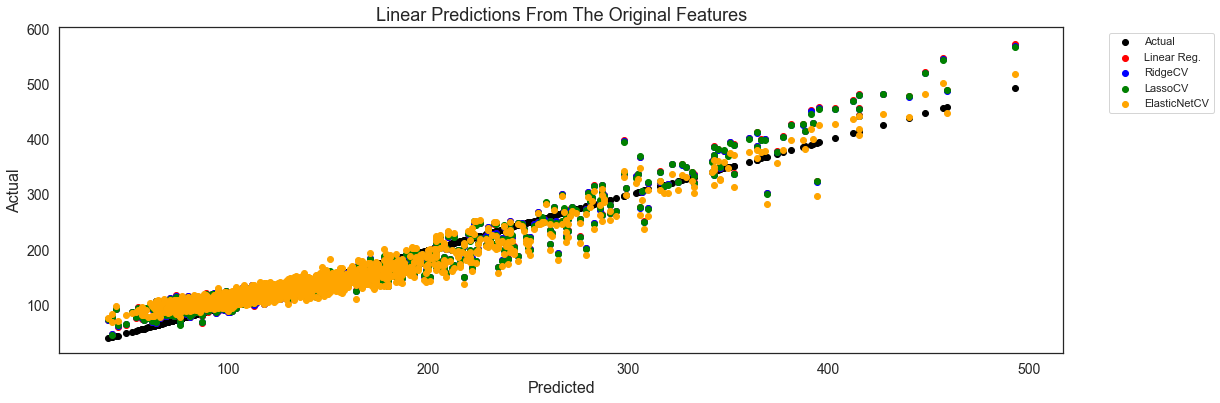

In [88]:
plot_linear_predictions(df    = original_features, 
                        true  = "Actual", 
                        title = "Original Features")

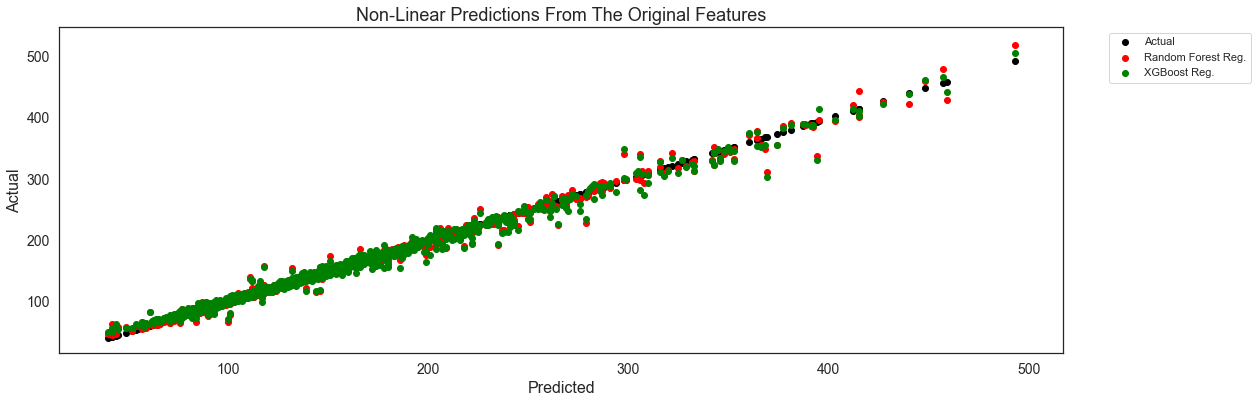

In [89]:
plot_nonlinear_predictions(df    = original_features, 
                           true  = "Actual", 
                           title = "Original Features")

The four linear models performed the best on values <200 given that the points there are overlapping so much.  However for values >200, the predictions follow the actual values but they became much more varied.

On the other hand, the non-linear models followed the true line much more closely.  Although the variance increased as the values increased, it is not nearly as dramatic as with the linear models

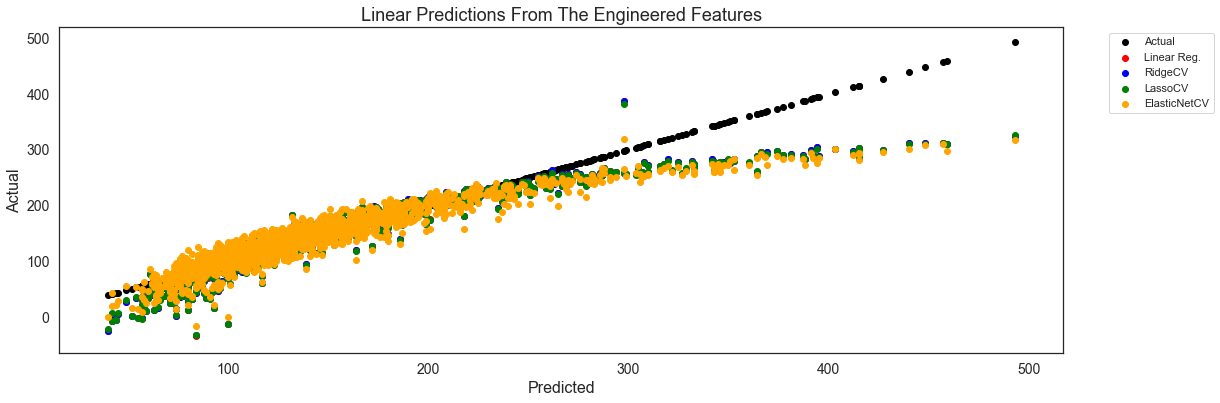

In [90]:
plot_linear_predictions(df    = engineered_features, 
                        true  = "Actual", 
                        title = "Engineered Features")

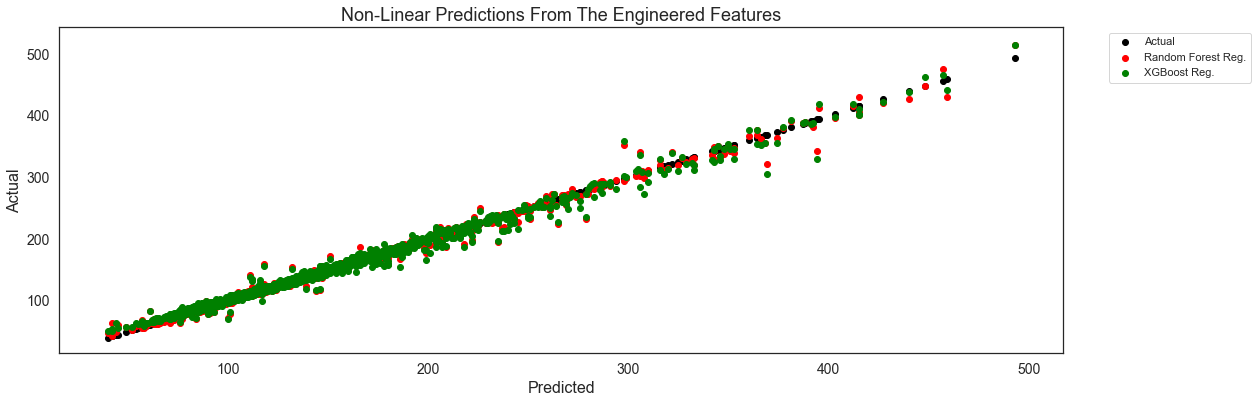

In [91]:
plot_nonlinear_predictions(df    = engineered_features, 
                           true  = "Actual", 
                           title = "Engineered Features")

The linear models have a very distinct curve where the accuracy begins to flatten and become much less accurate.  This is because of how heteroscedastic the models are.  

On the other hand the non-linear models are much more accurate and follow a straight line much more closely.

[Top](#Table-Of-Contents)

### Plotting Residuals

The residuals are simply the difference between the actual values and the predicted values.  Looking at the residuals allows us to detect if the independence of errors assumption is violated.

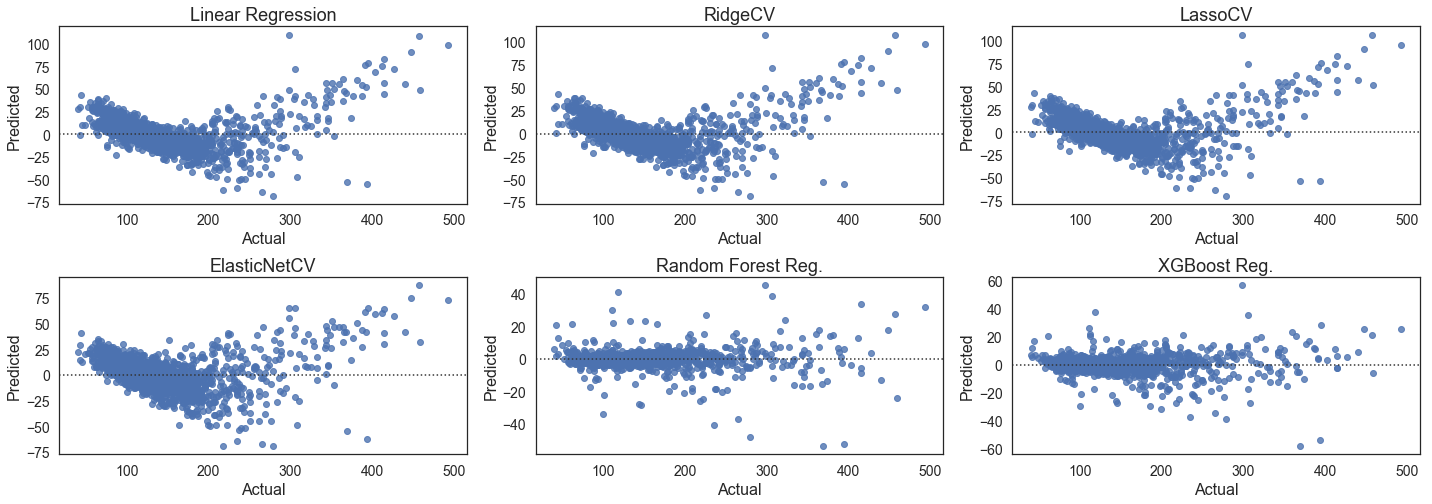

In [92]:
plot_residuals(df      = original_features,
               columns = ["Linear Reg.", "RidgeCV",
                          "LassoCV", "ElasticNetCV",
                          "Random Forest Reg.", "XGBoost Reg."],
               titles  = ["Linear Regression", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."])

The residual plots of the linear models are not at all surprising given the distribution of my predicted values: they are dense for low values and very disperse for high values.  That means that the data is heteroscedastic, which means that it is violating one of the assumptions of linear models: independence of errors; ideally the points would be scattered randomly along the horizontal line.

The two non-linear models are magnitudes better: the points are scattered along the line indicating that the independence of errors is not violated.

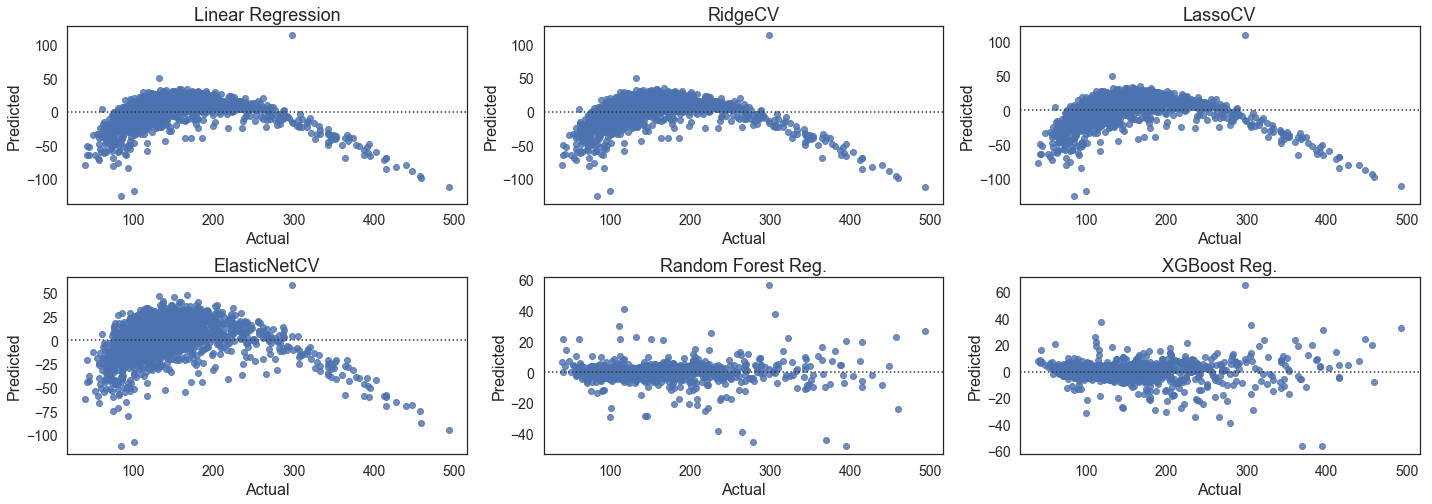

In [93]:
plot_residuals(df      = engineered_features,
               columns = ["Linear Reg.", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."],
               titles  = ["Linear Regression", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."])

These residual plots of the linear models are not at all surprising given the distribution of my predicted values: they are dense for low values and very disperse for high values.  It is easy to see where the models were under-performing for low values and high values. As a result, this data is also heteroscedastic.

However the non-linear models are homoscedastic (the opposite of heteroscedastic).

[Top](#Table-Of-Contents)

### Final Model Choice

Model Performance With The Four Metrics With The Original Features:
    
| Metric                 | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-----------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| **RMSE**               | 17.47             | 17.46   | 17.45   | 18.71        | 5.750                    | 6.801              |
| **MAE**                | 12.90             | 12.93   | 12.93   | 14.38        | 2.907                    | 4.012              |
| **R<sup>2</sup>**      | 0.9237            | 0.9238  | 0.9239  | 0.9125       | 0.9917                   | 0.9884             |
| **Adj. R<sup>2</sup>** | 0.9231            | -----   | -----   | -----        | 0.9916                   | 0.9883             |


Model Performance With The Four Metrics With The Engineered Features:

| Metric                 | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-----------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| **RMSE**               | 23.30             | 23.11   | 23.16   | 24.88        | 5.429                    | 6.787              |
| **MAE**                | 14.59             | 15.23   | 15.29   | 16.69        | 2.770                    | 3.961              |    
| **R<sup>2</sup>**      | 0.8666            | 0.86    | 0.8659  | 0.8454       | 0.9926                   | 0.9884             |
| **Adj. R<sup>2</sup>** | 0.8662            | -----   | -----   | -----        | 0.9926                   | 0.9884             |


Once we had run the non-linear models, it was readily apparent to us that they were far superior to the linear models.  To that end, we chose two models as our final models:

- XGBoost Regression with the engineered features for interpretation.

- Random Forest Regression with the engineered features for accuracy.

We chose to have two final models because we wanted to produce a model that is as accurate as possible while also having a model that would be easy for us to talk about.

[Top](#Table-Of-Contents)